In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score

data = pd.read_csv('pseudodata_præoperation.csv')

# # #make pd to np
X = data.to_numpy()
y = np.random.choice([0, 1], size=len(data))

X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
holdout_indices = indices[:500]
remaining_indices = indices[500:]

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, remaining_indices)

# Define the ANN model with L2 regularization
class DeepANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepANNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
            for i, hidden_dim in enumerate(hidden_dims)
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.sigmoid(self.output_layer(x))
        return x

input_dim = 575
hidden_dims = [128,64]
output_dim = 2

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dim, output_dim, num_epochs=10, lr=0.01, weight_decay=1e-5):
    model = DeepANNModel(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy, model

# Outer 10-Fold Cross-Validation
outer_kf = KFold(n_splits=2, shuffle=True, random_state=42)
outer_accuracies = []
best_model_params = None
best_outer_accuracy = 0

for outer_train_index, outer_test_index in outer_kf.split(remaining_indices):
    outer_train_subset = Subset(remaining_set, outer_train_index)
    outer_test_subset = Subset(remaining_set, outer_test_index)
    
    # Inner 10-Fold Cross-Validation
    inner_kf = KFold(n_splits=2, shuffle=True, random_state=42)
    inner_accuracies = []

    for inner_train_index, inner_val_index in inner_kf.split(outer_train_index):
        inner_train_indices = np.array(outer_train_index)[inner_train_index]
        inner_val_indices = np.array(outer_train_index)[inner_val_index]
        
        inner_train_subset = Subset(remaining_set, inner_train_indices)
        inner_val_subset = Subset(remaining_set, inner_val_indices)
        
        train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
        
        accuracy, model = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, output_dim)
        inner_accuracies.append(accuracy)
        print(f'Inner Fold Accuracy: {accuracy * 100:.2f}%')

    mean_inner_accuracy = np.mean(inner_accuracies)
    print(f'Outer Fold Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')

    train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
    test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
    
    outer_accuracy, outer_model = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims, output_dim)
    outer_accuracies.append(outer_accuracy)
    print(f'Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')

    if outer_accuracy > best_outer_accuracy:
        best_outer_accuracy = outer_accuracy
        best_model_params = outer_model.state_dict()

print(f'Mean Outer Accuracy: {np.mean(outer_accuracies) * 100:.2f}%')
print('Best model parameters:', best_model_params)

# Evaluate the final model on the holdout set
final_model = DeepANNModel(input_dim, hidden_dims, output_dim)
final_model.load_state_dict(best_model_params)
train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

#Calculate recall
holdout_outputs = []
holdout_targets = []
for images, labels in holdout_loader:
    outputs = final_model(images)
    holdout_outputs.append(outputs)
    holdout_targets.append(labels)
holdout_outputs = torch.cat(holdout_outputs).detach().numpy()
holdout_targets = torch.cat(holdout_targets).detach().numpy()


# Train the final model on the remaining set and evaluate on the holdout set
final_model_accuracy, _ = train_and_evaluate_model(train_loader, holdout_loader, input_dim, hidden_dims, output_dim)
holdout_recall = recall_score(holdout_targets, np.round(holdout_outputs))
print(f'Holdout Set Accuracy: {final_model_accuracy * 100:.2f}%', f'Holdout Set Recall: {holdout_recall * 100:.2f}%')


Inner Fold Accuracy: 50.07%
Inner Fold Accuracy: 49.33%
Outer Fold Mean Inner Accuracy: 49.70%
Outer Fold Accuracy: 51.08%
Inner Fold Accuracy: 48.21%
Inner Fold Accuracy: 50.37%
Outer Fold Mean Inner Accuracy: 49.29%
Outer Fold Accuracy: 50.00%
Mean Outer Accuracy: 50.54%
Best model parameters: OrderedDict({'hidden_layers.0.weight': tensor([[-2.3194e-02,  1.2236e-02,  2.3839e-02,  ..., -2.2295e-02,
         -1.9117e-02,  7.6507e-03],
        [-2.7324e-02,  2.3407e-02, -2.1868e-02,  ..., -3.8285e-02,
          2.3791e-02,  6.8445e-03],
        [-1.0789e-02,  3.2638e-03,  1.4614e-02,  ...,  9.1866e-03,
         -3.0250e-02, -3.3283e-02],
        ...,
        [-3.8520e-02, -1.0740e-02, -1.3193e-02,  ...,  2.9176e-02,
          7.8935e-03, -7.5400e-03],
        [-1.9616e-03,  1.2122e-02, -3.7578e-02,  ..., -1.1434e-02,
         -3.1245e-02, -2.9603e-02],
        [ 1.6590e-02, -1.4597e-02,  7.1674e-03,  ..., -2.8120e-05,
          1.8489e-02, -5.8273e-03]]), 'hidden_layers.0.bias': tensor(

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

Inner Fold Accuracy: 50.41%
Inner Fold Accuracy: 45.04%
Inner Fold Accuracy: 50.00%
Inner Fold Accuracy: 45.04%
Inner Fold Accuracy: 51.24%
Inner Fold Accuracy: 43.39%
Inner Fold Accuracy: 54.77%
Inner Fold Accuracy: 48.55%
Inner Fold Accuracy: 55.60%
Inner Fold Accuracy: 51.04%
Outer Fold Mean Inner Accuracy: 49.51%
Outer Fold Accuracy: 49.81%
Inner Fold Accuracy: 45.45%
Inner Fold Accuracy: 53.72%
Inner Fold Accuracy: 48.35%
Inner Fold Accuracy: 53.31%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 47.30%
Inner Fold Accuracy: 57.68%
Inner Fold Accuracy: 53.11%
Inner Fold Accuracy: 56.02%
Outer Fold Mean Inner Accuracy: 51.25%
Outer Fold Accuracy: 46.47%
Inner Fold Accuracy: 46.28%
Inner Fold Accuracy: 52.07%
Inner Fold Accuracy: 47.93%
Inner Fold Accuracy: 46.28%
Inner Fold Accuracy: 44.63%
Inner Fold Accuracy: 48.76%
Inner Fold Accuracy: 46.47%
Inner Fold Accuracy: 53.11%
Inner Fold Accuracy: 55.19%
Inner Fold Accuracy: 44.81%
Outer Fold Mean Inner Accu

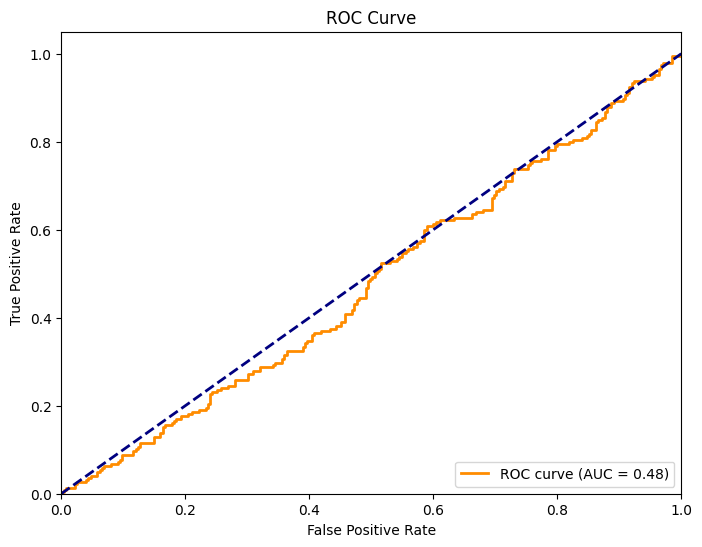

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('pseudodata_præoperation.csv')

# Convert data to numpy arrays
X = data.to_numpy()
y = np.random.choice([0, 1], size=len(data))

X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  # Note: use float32 for BCEWithLogitsLoss

# Create a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split data into holdout set and remaining set
indices = np.arange(len(dataset))
np.random.seed(42)
np.random.shuffle(indices)
holdout_indices = indices[:500]
remaining_indices = indices[500:]

holdout_set = Subset(dataset, holdout_indices)
remaining_set = Subset(dataset, remaining_indices)

# Define the deep ANN model with L2 regularization
class DeepANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(DeepANNModel, self).__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim)
            for i, hidden_dim in enumerate(hidden_dims)
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

input_dim = 575
hidden_dims = [128, 64]

# Function to train and evaluate the model with L2 regularization
def train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims, num_epochs=10, lr=0.01, weight_decay=1e-5):
    model = DeepANNModel(input_dim, hidden_dims)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images).squeeze()
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    return accuracy, model

# Outer 10-Fold Cross-Validation
outer_kf = KFold(n_splits=10, shuffle=True, random_state=42)
outer_accuracies = []
best_model_params = None
best_outer_accuracy = 0

for outer_train_index, outer_test_index in outer_kf.split(remaining_indices):
    outer_train_subset = Subset(remaining_set, outer_train_index)
    outer_test_subset = Subset(remaining_set, outer_test_index)
    
    # Inner 10-Fold Cross-Validation
    inner_kf = KFold(n_splits=10, shuffle=True, random_state=42)
    inner_accuracies = []

    for inner_train_index, inner_val_index in inner_kf.split(outer_train_index):
        inner_train_indices = np.array(outer_train_index)[inner_train_index]
        inner_val_indices = np.array(outer_train_index)[inner_val_index]
        
        inner_train_subset = Subset(remaining_set, inner_train_indices)
        inner_val_subset = Subset(remaining_set, inner_val_indices)
        
        train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
        
        accuracy, model = train_and_evaluate_model(train_loader, val_loader, input_dim, hidden_dims)
        inner_accuracies.append(accuracy)
        print(f'Inner Fold Accuracy: {accuracy * 100:.2f}%')

    mean_inner_accuracy = np.mean(inner_accuracies)
    print(f'Outer Fold Mean Inner Accuracy: {mean_inner_accuracy * 100:.2f}%')

    train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
    test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
    
    outer_accuracy, outer_model = train_and_evaluate_model(train_loader, test_loader, input_dim, hidden_dims)
    outer_accuracies.append(outer_accuracy)
    print(f'Outer Fold Accuracy: {outer_accuracy * 100:.2f}%')

    if outer_accuracy > best_outer_accuracy:
        best_outer_accuracy = outer_accuracy
        best_model_params = outer_model.state_dict()

print(f'Mean Outer Accuracy: {np.mean(outer_accuracies) * 100:.2f}%')
print('Best model parameters:', best_model_params)

# Evaluate the final model on the holdout set
final_model = DeepANNModel(input_dim, hidden_dims)
final_model.load_state_dict(best_model_params)
train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

# Evaluate the final model on the holdout set
final_model.eval()
holdout_outputs = []
holdout_targets = []
with torch.no_grad():
    for inputs, labels in holdout_loader:
        outputs = final_model(inputs).squeeze()
        probabilities = torch.sigmoid(outputs)  # Get the probabilities for the positive class
        holdout_outputs.extend(probabilities.numpy())
        holdout_targets.extend(labels.numpy())

# Convert holdout outputs to binary predictions
holdout_predictions = np.round(holdout_outputs)

holdout_accuracy = accuracy_score(holdout_targets, holdout_predictions)
holdout_recall = recall_score(holdout_targets, holdout_predictions)
print(f'Holdout Set Accuracy: {holdout_accuracy * 100:.2f}%')
print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%')

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(holdout_targets, holdout_outputs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
